In [1]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

from utils import *


```python
for t in range(0,T):
    w[t+1] = w[t] - eta*Df/dw[t]

# where f is the function to be minimized (loss function) and w is the weights
```

In [122]:
class SimpleGraph:
  """
  Implementing Simple Computational Graph
  """

  def __init__(self, w, b):
    """
    Initializing the SimpleGraph

    Args:
      w: float
        Initial value for weight
      b: float
        Initial value for bias

    Returns:
      Nothing
    """
    assert isinstance(w, float)
    assert isinstance(b, float)
    self.w = torch.tensor([w], requires_grad=True)
    self.b = torch.tensor([b], requires_grad=True)

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.Tensor
        1D tensor of features

    Returns:
      prediction: torch.Tensor
        Model predictions
    """
    assert isinstance(x, torch.Tensor)
    prediction = torch.tanh(x * self.w + self.b)
    return prediction


def sq_loss(y_true, y_prediction):
  """
  L2 loss function

  Args:
    y_true: torch.Tensor
      1D tensor of target labels
    y_prediction: torch.Tensor
      1D tensor of predictions

  Returns:
    loss: torch.Tensor
      L2-loss (squared error)
  """
  assert isinstance(y_true, torch.Tensor)
  assert isinstance(y_prediction, torch.Tensor)
  loss = (y_true - y_prediction)**2
  return loss



feature = torch.tensor([2])  # Input tensor
target = torch.tensor([7])  # Target tensor
## Uncomment to run
simple_graph = SimpleGraph(-0.5, 0.5)
print(f"initial weight = {simple_graph.w.item()}, "
      f"\ninitial bias = {simple_graph.b.item()}")
prediction = simple_graph.forward(feature)
square_loss = sq_loss(target, prediction)
print(f"for x={feature.item()} and y={target.item()}, "
      f"prediction={prediction.item()}, and L2 Loss = {square_loss.item()}")

initial weight = -0.5, 
initial bias = 0.5
for x=2 and y=7, prediction=-0.46211716532707214, and L2 Loss = 55.68319320678711


In [123]:
a = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([-1.0], requires_grad=True)
c = a+b
c.retain_grad()
c.backward()
c.grad

tensor([1.])

In [127]:
prediction = simple_graph.forward(feature)

# analytical gradients
ana_dloss_dw = -2*feature * (target - prediction) * (1-prediction**2)
ana_dloss_db = -2 * (target - prediction) * (1 - prediction**2)

square_loss.backward(retain_graph=True) # call backward to build the graph
autograd_dloss_dw = simple_graph.w.grad
autograd_dloss_db = simple_graph.b.grad

simple_graph.w.grad.zero_()
simple_graph.b.grad.zero_()

autograd_dloss_dw, autograd_dloss_db, simple_graph.w, simple_graph.b, prediction

(tensor([0.]),
 tensor([0.]),
 tensor([-0.5000], requires_grad=True),
 tensor([0.5000], requires_grad=True),
 tensor([-0.4621], grad_fn=<TanhBackward0>))

#### Training Loop in Pytorch

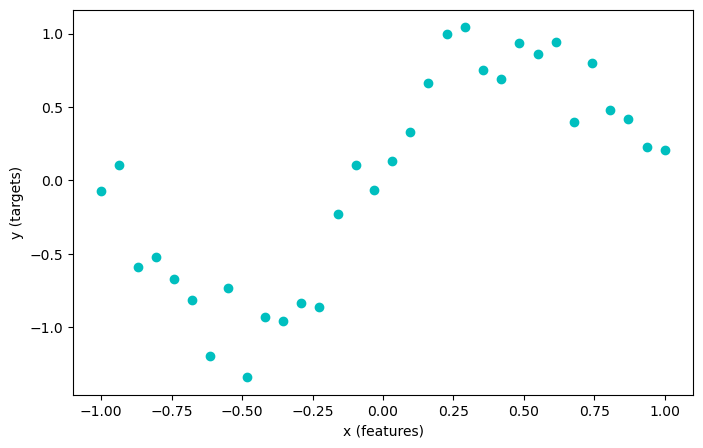

In [137]:
# generate dataset
n_samples = 32
features = torch.linspace(-1.0, 1.0, n_samples).reshape(n_samples, 1)
noise = torch.randn(n_samples, 1) / 4
targets = torch.sin(np.pi * features) + noise
plt.figure(figsize=(8, 5))
plt.scatter(features, targets, c='c')
plt.xlabel('x (features)')
plt.ylabel('y (targets)')
plt.show()

In [138]:
class WideNet(nn.Module):
    
    '''def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)'''
    
    def __init__(self):
        super(WideNet, self).__init__() # in solution WideNet and self are not included in super. why?
        
        ncells = 512
        self.layers = nn.Sequential(
            nn.Linear(1, ncells),
            nn.Tanh(),
            nn.Linear(ncells,1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass
        """
        
        return self.layers(x)

In [139]:
model = WideNet()
model

WideNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [141]:
# define loss function (MSE because this is regression, I think)
loss_function = nn.MSELoss()

# define optimizer - stochastic gradient descent - for model parameters and hyperparameters
lr = 0.003
sgd_optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)

In [142]:
# zero out gradients
sgd_optimizer.zero_grad()

# make prediction with current model parameters
prediction = model(features)

# calculate loss
loss = loss_function(prediction, targets)

# do backpropagation with calculated loss for current model prediction
loss.backward()

# update parameters (weights and biases) of model by going a step in direction of steepest descent in loss landscape
sgd_optimizer.step()

#### Training Loop

In [ ]:
def train(model, features, labels, loss_fun, optimizer, nepochs):

    losses = []

    for iepoch in range(nepochs):

        optimizer.zero_grad()

        prediction = model.forward(features)

        loss = loss_fun(prediction, labels)

        losses.append(loss.item())

        if iepoch % 20 == 0:
            print(f'Epoch {iepoch}, loss {loss.item()}')

        loss.backward()

        optimizer.step()

    return losses

In [147]:
n_epochs = 100

losses = train(model=model, features=features, labels=targets, loss_fun=loss_function, optimizer=sgd_optimizer, nepochs=n_epochs)

Epoch 0, loss 0.5157279968261719
Epoch 20, loss 0.2792746126651764
Epoch 40, loss 0.2280653864145279
Epoch 60, loss 0.2171352505683899
Epoch 80, loss 0.20981833338737488


#### Derivation by finite differences vs analytical solution

In [32]:
def fun_z(x, y):
  """
  Implements function sin(x^2 + y^2)

  Args:
    x: (float, np.ndarray)
      Variable x
    y: (float, np.ndarray)
      Variable y

  Returns:
    z: (float, np.ndarray)
      sin(x^2 + y^2)
  """
  z = np.sin(x**2 + y**2)
  return z


def fun_dz_num(x, y):
  """
  Implements function sin(x^2 + y^2)

  Args:
    x: (float, np.ndarray)
      Variable x
    y: (float, np.ndarray)
      Variable y

  Returns:
    Tuple of gradient vector for sin(x^2 + y^2)
  """
  #################################################
  ## Implement the function which returns gradient vector
  ## Complete the partial derivatives dz_dx and dz_dy
  # Complete the function and remove or comment the line below
  #raise NotImplementedError("Gradient function `fun_dz`")
  #################################################
  dz_dx = (fun_z(x[1:], y[1:])-fun_z(x[:-1], y[:-1]))/np.diff(x)
  dz_dy = (fun_z(x[1:], y[1:])-fun_z(x[:-1], y[:-1]))/np.diff(y)
  return (dz_dx, dz_dy)


def fun_dz_anal(x, y):
  """
  Implements function sin(x^2 + y^2)

  Args:
    x: (float, np.ndarray)
      Variable x
    y: (float, np.ndarray)
      Variable y

  Returns:
    Tuple of gradient vector for sin(x^2 + y^2)
  """
  dz_dx = 2 * x * np.cos(x**2 + y**2)
  dz_dy = 2 * y * np.cos(x**2 + y**2)
  return (dz_dx, dz_dy)


## Uncomment to run
#ex1_plot(fun_z, fun_dz)
x, y = np.arange(-3, 3.01, 0.02), np.arange(-3, 3.01, 0.02)


'''xx, yy = np.meshgrid(x, y, sparse=True)
zz = fun_z(xx, yy)
xg, yg = np.arange(-2.5, 2.6, 0.5), np.arange(-2.5, 2.6, 0.5)
xxg, yyg = np.meshgrid(xg, yg, sparse=True)
zxg, zyg = fun_dz(xxg, yyg)'''
#fun_dz()

'xx, yy = np.meshgrid(x, y, sparse=True)\nzz = fun_z(xx, yy)\nxg, yg = np.arange(-2.5, 2.6, 0.5), np.arange(-2.5, 2.6, 0.5)\nxxg, yyg = np.meshgrid(xg, yg, sparse=True)\nzxg, zyg = fun_dz(xxg, yyg)'

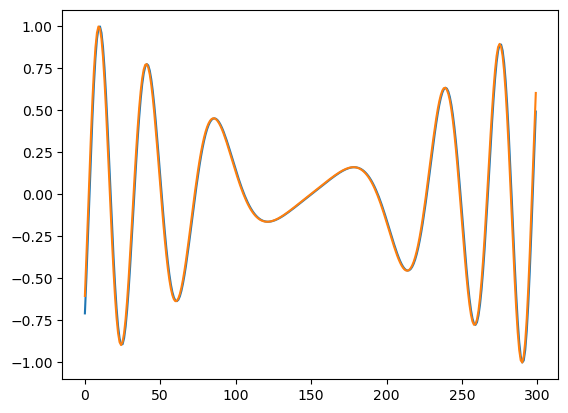

In [34]:
plt.plot(fun_dz_anal(x, y)[0][:-1]/fun_dz_anal(x,y)[0].max())
plt.plot(fun_dz_num(x,y)[0]/fun_dz_num(x,y)[0].max())
#plt.plot(fun_z(x,y))